In [1]:
import os
import sys
import pygsheets
import math
import numpy as np
import pandas as pd
import ams_utilities as au
from openpyxl import load_workbook
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from itertools import cycle
import scipy
%matplotlib notebook
import pyabf
import scipy.interpolate
import matplotlib.pyplot as plt
import scipy.stats as ss 
from itertools import product
from ams_paq_utilities import *
from ams_utilities import *
# sns.set()
# sns.set_style('white')
# params = {'legend.fontsize': 'x-large',
#          'axes.labelsize': 'xx-large',
#          'axes.titlesize':'xx-large',
#          'xtick.labelsize':'xx-large',
#          'ytick.labelsize':'xx-large'}
# plt.rcParams.update(params)

In [6]:
#import morph data from google sheet (actually from .csv saved from google sheet bc of google permissions)
# df_all=GS_to_df('https://docs.google.com/spreadsheets/d/1ziOx80em0ZhmMmSjKePYbOq3K6sHcOapfHjy9S4oDbk/edit#gid=662691853')
df_all=pd.read_csv(r'E:\Jake\Morph_analysis.csv')
df_all.index=df_all.iloc[:,0]
df_all=df_all.drop('Mouse#: Cell', axis=1)
df_all

,AS016: Cell1,AS016: Cell2,AS029: Cell1,AS030: Cell1,AS035: Cell1,AS036: Cell1,AS038: Cell1,AS039: Cell1,AS039: Cell2,AS040: Cell1,...,AS276: Cell2,AS277: Cell1,AS277: Cell2,AS277: Cell3,AS278: Cell2,AS278: Cell3,AS278: Cell4,AS278: Cell5,AS279: Cell1,AS280: Cell2
Mouse#: Cell,,,,,,,,,,,,,,,,,,,,,
Slice_Orientation,H,H,H,H,H,C,H,H,H,H,...,C,C,C,C,C,C,C,C,C,C
Axon_node_total,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Axon_length,1620.49,0,28.4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Axon_SA,10859.8,0,104.62,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Axon_length_to_SA_ratio,0.15,NaN,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Highest_order_axon_segment,4,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Axon_polar_angle,58.31666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Axon_polar_angle_std,38.83025609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Axon_local_angle,80.43333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Eliminate rows containing redundant, uninformative or incomplete (NaN) data
# In this instance -- will focus on dendritic data and soma perimeter, drop everything ele 
dattab = df_all.iloc[25:69,:]
dattab = dattab.drop(['Soma_surace_area',
                     'Soma_volume',
                     'Soma_aspect_ration',
                     'Soma_compactness_factor',
                     'Soma_form_factor',
                     'Somatic_roundness',
                     'Dendrite_max_extent',
                     'Dendrite_SA',
                     'Dendrite_length_to_SA_ratio',
#                      'Dendrite_polar_longest_bin', #Removed because it doesn't seem like a sensible metric 
                     'AP Coords',
#                      'DV Coords',
#                      'ML Coords'
                     ],0)
#Drop cells that we've decided are bad
dattab=dattab.drop(['AS035: Cell1',
#                     'AS039: Cell2', #neurogliaform cell
                    'AS057: Cell3',
                    'AS062: Cell3',
                    'AS063: Cell3',
                    'AS091: Cell3',
                    'AS132: Cell3',
                    'AS143: Cell3',
#7 outliers
#                     'AS040: Cell1',
#                     'AS152: Cell1',
#                     'AS062: Cell2',
#                     'AS059: Cell2',
#                     'AS117: Cell4',
#                     'AS115: Cell1',
#                     'AS071: Cell1'
                    ], 1)

# #Add spiny-ness metric
# spines=pd.read_excel('E:\Jake\spinyness.xlsx', names=['Spinyness measure'], usecols='F', squeeze=True)
# spines.index=dattab.columns
# dattab=dattab.append(spines)
# dattab=dattab.dropna(axis=1)

# Convert to float array and standardise data ((x - mean)/std)
dattab = au.str_flt(dattab.iloc[:,:])
dattab -= np.mean(dattab)
dattab /= np.std(dattab)

# # Transpose array so variables arranged column-wise 
data = dattab.T
# data.columns.names = ["metric"]
# data.index.names = ["cell"]
data

Mouse#: Cell,Dendrite_node_total,Total_dendrite_length,Average_dendrite_length,Highest_order_dendrite_segment,Dendrite_polar_angle,Dendrite_polar_angle_std,Dendrite_local_angle,Dendrite_local_angle_std,Dendrite_spline_angle,Dendrite_spline_angle_std,...,Dendrite_sholl_number_10,Dendrite_sholl_number_50,Dendrite_sholl_number_100,Dendrite_sholl_number_200,Dendrite_sholl_number_300,Soma_perimeter,Dendrite_polar_length_mean,Dendrite_polar_length_std,Dendrite_polar_length_variance,Dendrite_polar_longest_bin
AS016: Cell1,-0.212202,5.420372,0.870809,-0.249228,-0.214855,-0.228184,-0.201895,-0.232058,-0.203283,-0.229125,...,-0.256171,-0.245757,-0.253857,-0.257328,-0.259642,-0.138137,-0.266123,-0.266340,-0.266533,0.034255
AS016: Cell2,-0.270819,5.214370,0.600041,-0.295292,-0.143530,-0.179401,-0.111758,-0.207534,-0.123340,-0.202628,...,-0.295292,-0.270819,-0.316707,-0.322825,-0.322825,-0.150501,-0.321508,-0.322051,-0.322629,0.105462
AS029: Cell1,-0.307338,5.218399,0.577990,-0.322882,-0.143282,-0.195427,-0.092376,-0.174654,-0.126802,-0.181554,...,-0.322882,-0.303453,-0.330654,-0.350084,-0.350084,-0.157575,-0.348628,-0.348917,-0.349734,0.971129
AS030: Cell1,-0.211473,5.511148,0.263291,-0.239742,-0.131739,-0.165968,-0.109976,-0.179316,-0.123301,-0.180948,...,-0.235393,-0.233219,-0.250615,-0.252790,-0.259313,-0.099377,-0.260776,-0.260973,-0.261366,-0.044035
AS036: Cell1,-0.250479,5.378954,1.136722,-0.255220,-0.174931,-0.208312,-0.174065,-0.204679,-0.172930,-0.198005,...,-0.269443,-0.267863,-0.267863,-0.264702,-0.272604,-0.205232,-0.276755,-0.276939,-0.277241,-0.056091
AS038: Cell1,-0.248230,5.310467,1.106402,-0.278783,-0.191613,-0.229584,-0.161840,-0.221535,-0.167878,-0.217004,...,-0.282378,-0.268000,-0.273391,-0.293161,-0.294958,-0.169781,-0.294133,-0.294632,-0.294899,-0.115234
AS039: Cell1,-0.195386,5.326040,1.111806,-0.275463,-0.208281,-0.228715,-0.203494,-0.230234,-0.207650,-0.229978,...,-0.282743,-0.266727,-0.262359,-0.291478,-0.292934,-0.125369,-0.292382,-0.292561,-0.292839,0.202087
AS039: Cell2,-0.042107,4.886697,0.398750,-0.296067,-0.163156,-0.247967,-0.148575,-0.246216,-0.157582,-0.240168,...,-0.263584,-0.346269,-0.349222,-0.349222,-0.349222,-0.221385,-0.347335,-0.348672,-0.349120,0.536685
AS040: Cell1,-0.235908,5.350402,0.513149,-0.277826,-0.186297,-0.215702,-0.165466,-0.215488,-0.168420,-0.216057,...,-0.283542,-0.249246,-0.274015,-0.293069,-0.293069,-0.043504,-0.292411,-0.292614,-0.292960,0.049897
AS045: Cell1,-0.257114,5.224946,0.380713,-0.298311,-0.174518,-0.229635,-0.156916,-0.218735,-0.168984,-0.223550,...,-0.302647,-0.265787,-0.289638,-0.311320,-0.311320,-0.119996,-0.310434,-0.310843,-0.311215,0.339148


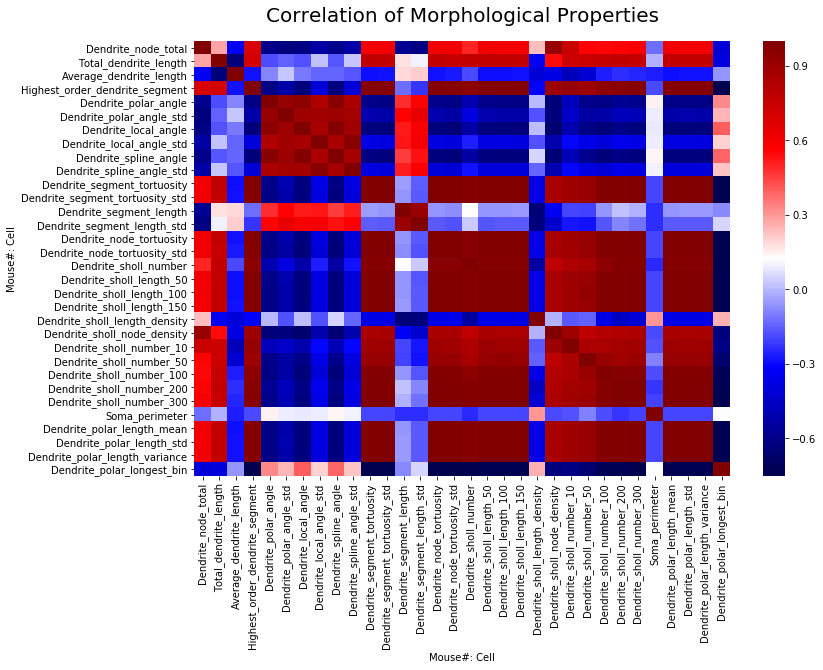

In [27]:
plt.figure(figsize=(12,8))
plt.title('Correlation of Morphological Properties', fontsize=20, y = 1.03);
dattabcor = dattab.T
cor = dattabcor.corr()
# cor = dattab.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.seismic)

plt.show()

In [28]:
# Perform PCA 
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(data)
pcList=['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5','principal component 6', 'principal component 7', 'principal component 8', 'principal component 9', 'principal component 10']

principalDf = pd.DataFrame(data=principalComponents, columns = pcList)
principalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,0.256517,-0.364273,-0.018841,-0.156859,0.050127,0.029470,-0.008161,0.012373,0.014809,0.003731
1,-0.582515,0.303854,-0.369225,0.118442,-0.044072,-0.032977,-0.010436,-0.016006,-0.006059,0.006871
2,-0.423423,0.454041,0.588598,-0.070522,-0.036528,-0.030959,0.024448,-0.029333,-0.002324,-0.016377
3,-0.182978,-0.770045,0.133555,0.030393,0.064234,0.107886,0.008301,-0.000687,-0.007039,0.006222
4,0.584649,-0.348398,-0.042855,-0.030811,-0.017826,0.003425,-0.008346,0.006403,0.009127,-0.007300
5,0.251759,-0.032292,-0.349634,0.008074,-0.007979,-0.038781,-0.027302,0.006020,0.038633,-0.009740
6,0.309664,0.014416,-0.040795,-0.191418,0.069073,0.037023,-0.048161,0.033663,0.014031,-0.011464
7,-1.227274,0.982033,-0.410118,-0.079401,-0.173524,0.187029,0.138684,0.103855,0.008621,-0.019581
8,-0.423361,-0.079636,-0.226490,-0.010453,0.090900,-0.016378,0.012192,-0.002791,0.007273,-0.001802
9,-0.796868,0.300563,-0.164118,-0.031497,-0.017515,-0.028298,0.042281,-0.029175,-0.008869,0.022963


In [29]:
# SANITY CHECK - do values correlate as expected
def corrank(X):
        import itertools
        df = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
        print(df.sort_values(by='corr',ascending=False))

print ('Top Correlations')
corrank(data)

Top Correlations
                                                 pairs      corr
493  (Dendrite_polar_length_std, Dendrite_polar_len...  0.999995
428  (Dendrite_sholl_length_150, Dendrite_polar_len...  0.999990
427  (Dendrite_sholl_length_150, Dendrite_polar_len...  0.999984
491  (Dendrite_polar_length_mean, Dendrite_polar_le...  0.999971
416  (Dendrite_sholl_length_100, Dendrite_polar_len...  0.999970
490  (Dendrite_polar_length_mean, Dendrite_polar_le...  0.999967
415  (Dendrite_sholl_length_100, Dendrite_polar_len...  0.999966
405  (Dendrite_sholl_length_100, Dendrite_sholl_len...  0.999957
426  (Dendrite_sholl_length_150, Dendrite_polar_len...  0.999953
414  (Dendrite_sholl_length_100, Dendrite_polar_len...  0.999950
304  (Dendrite_segment_tortuosity_std, Dendrite_pol...  0.999944
401  (Dendrite_sholl_length_50, Dendrite_polar_leng...  0.999943
303  (Dendrite_segment_tortuosity_std, Dendrite_pol...  0.999932
302  (Dendrite_segment_tortuosity_std, Dendrite_pol...  0.999932
293  (De

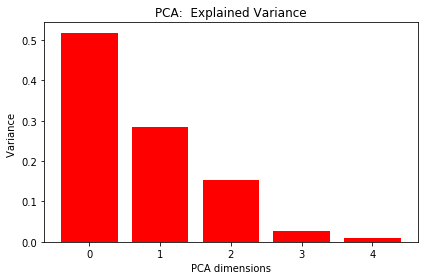

In [30]:
# # Perform PCA (assuming no of appropriate factors has already been determined)
pca = PCA(n_components = 5).fit(data)
X_pca = pca.transform(data)
PCA_components = pd.DataFrame(X_pca)
plt.subplots()
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='red')
plt.xlabel('PCA dimensions')
plt.ylabel('Variance ')
plt.title('PCA:  Explained Variance')
plt.tight_layout()
plt.savefig('E:\Jake\Morph_PCA_Explained_Variance')

In [31]:
print(pca.explained_variance_ratio_)

[0.5178 0.2849 0.1523 0.0276 0.0087]


In [32]:
loadings=pd.DataFrame(pca.components_, columns = data.columns, index = ['PC1','PC2','PC3','PC4','PC5'])


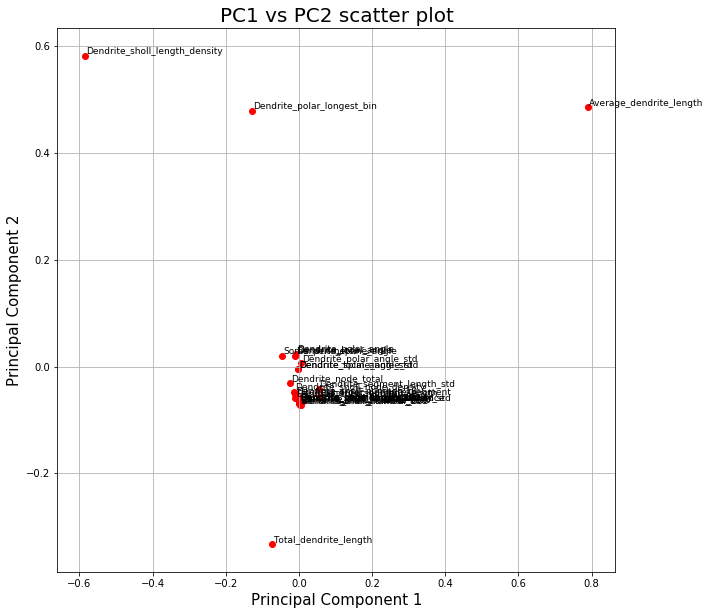

In [33]:
#PC1 & PC2 scatter plot
# plt.figure()
# labels = loadings.index 
# sns.scatterplot(x='PC1', y='PC2', data=loadings.iloc[:,[0,1]])
# plt.show()

PC1 = loadings.values[0]
PC2 = loadings.values[1]
labels = loadings.columns 

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(PC1,PC2, color='red')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PC1 vs PC2 scatter plot', fontsize = 20)
ax.grid()

for i,type in enumerate(labels):
    
    x = PC1[i]
    y = PC2[i]
    plt.text(x+0.003, y+0.003, type, fontsize=9)
    
    
plt.show()

In [34]:
loadings.values[:,0]

array([-0.0249, -0.0303, -0.0691, -0.1631, -0.086 ])

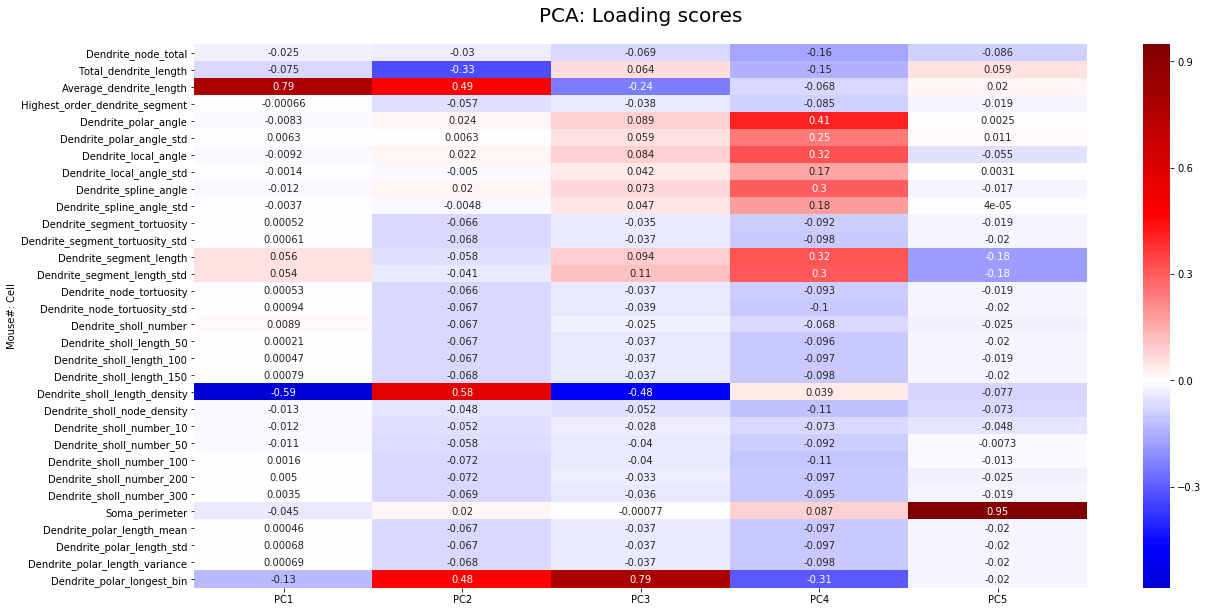

In [35]:
plt.figure(figsize=(20,10))
plt.tight_layout()
plt.title('PCA: Loading scores', fontsize=20, y = 1.03)
sns.heatmap(loadings.T, annot=True, cmap=plt.cm.seismic, center=0)
plt.savefig('E:\Jake\PCA_loading_scores.png')
plt.show()


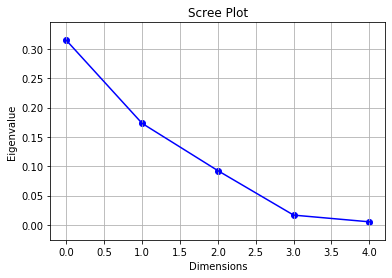

In [36]:
plt.subplots()
plt.scatter(features, pca.explained_variance_, color = 'blue')
plt.plot(features, pca.explained_variance_, color = 'blue')
plt.title('Scree Plot')
plt.xlabel('Dimensions')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


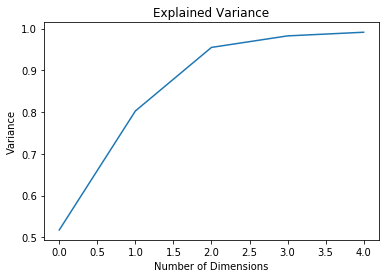

array([0.5178, 0.2849, 0.1523, 0.0276, 0.0087])

In [37]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Dimensions')
plt.ylabel('Variance') #for each component
plt.title('Explained Variance')
plt.show()

display(pca.explained_variance_ratio_)

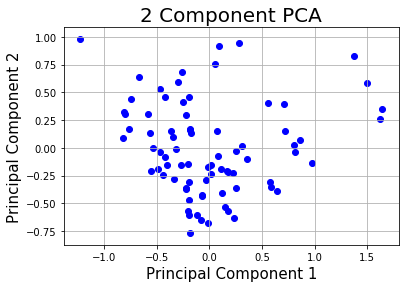

In [38]:
# Create plot of PC space (components 1/2)
fig, ax = plt.subplots()
plt.scatter(PCA_components[0], PCA_components[1], color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.grid()

In [39]:
# Re run PCA on appropraite number of components 
pca = PCA(n_components=3)
pca.fit_transform(data)


array([[ 0.2565, -0.3643, -0.0188],
       [-0.5825,  0.3039, -0.3692],
       [-0.4234,  0.454 ,  0.5886],
       ...,
       [-0.4346, -0.2476,  0.1024],
       [-0.1959, -0.4715,  0.0366],
       [ 0.9764, -0.1367, -0.1066]])

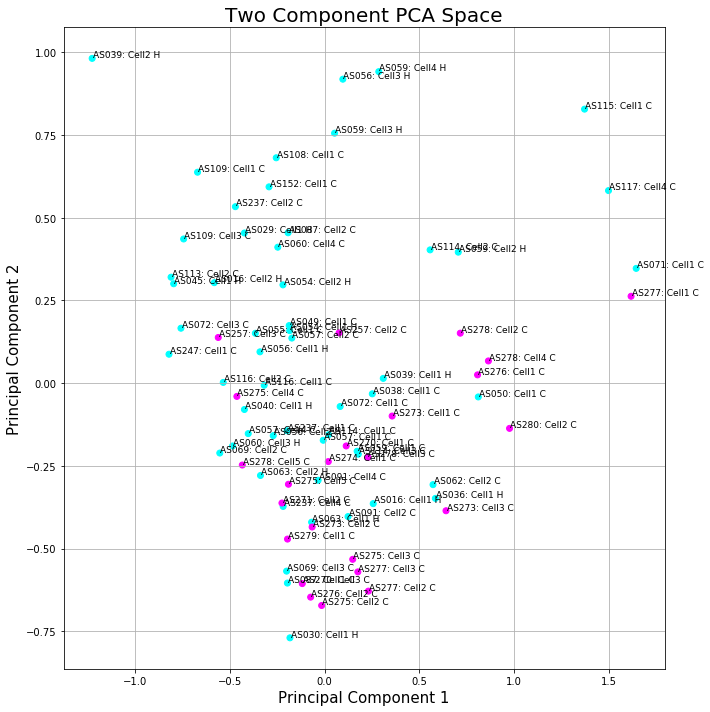

<Figure size 432x288 with 0 Axes>

In [40]:
# Create plot of PC space (components 1/2)
import matplotlib.colors
import matplotlib.artist
import matplotlib.patches as patch
import matplotlib.cm

#Adds type of microscope imaged on (for 79 cells only)
scopetype=np.append(np.zeros(55),np.ones(24))

P1 = PCA_components[0]
P2 = PCA_components[1]
labs=[]
for i in range(0,len(data.index)):
    labs.append(data.index[i]+' '+str(df_all.iloc[0,i]))
labels = labs


fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(P1,P2, c=scopetype, cmap='cool')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two Component PCA Space', fontsize = 20)
ax.grid()

for i,type in enumerate(labels):
    
    x = P1[i]
    y = P2[i]
    plt.text(x+0.003, y+0.003, type, fontsize=9)
    
plt.tight_layout()    
plt.show()
plt.savefig('E:\Jake\Morph_PCA')
P1morph=P1
P2morph=P2

In [41]:
x = np.array(PCA_components[0])
y = np.array(PCA_components[1])
z = np.array(PCA_components[2])
# w = np.array(PCA_components[3])
# u = np.array(PCA_components[4])

pc_df=pd.DataFrame([x,y], columns=data.index, index=['PC1','PC2'])
pc_df.to_csv('E:\Jake\morph_PCA.csv')

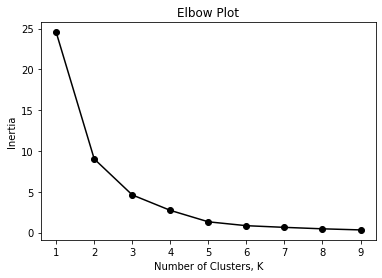

In [42]:
# You can assess appropriate number of clusters by identifying 'elbow' in KMeans Inertia plot 

X = np.column_stack((x,y,z))
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,0:1])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
fig, ax = plt.subplots()
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('Number of Clusters, K')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.xticks(ks)
plt.show()

#For k-means without PCA

# X=np.array(data)
# ks = range(1, 10)
# inertias = []
# for k in ks:
#     # Create a KMeans instance with k clusters
#     model = KMeans(n_clusters=k)
    
#     # Fit model to samples
#     model.fit(data)
    
#     # Append the inertia to the list of inertias
#     inertias.append(model.inertia_)
    
# fig, ax = plt.subplots()
# plt.plot(ks, inertias, '-o', color='black')
# plt.xlabel('Number of Clusters, K')
# plt.ylabel('Inertia')
# plt.title('Elbow Plot')
# plt.xticks(ks)
# plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4018008337692594
For n_clusters = 3 The average silhouette_score is : 0.34318636984164397
For n_clusters = 4 The average silhouette_score is : 0.34817495611303945
For n_clusters = 5 The average silhouette_score is : 0.3473439943480745
For n_clusters = 6 The average silhouette_score is : 0.32712596650597014
For n_clusters = 7 The average silhouette_score is : 0.32898806751549947
For n_clusters = 8 The average silhouette_score is : 0.3372166001626137
For n_clusters = 9 The average silhouette_score is : 0.3201700297935193
For n_clusters = 10 The average silhouette_score is : 0.31896918505445765


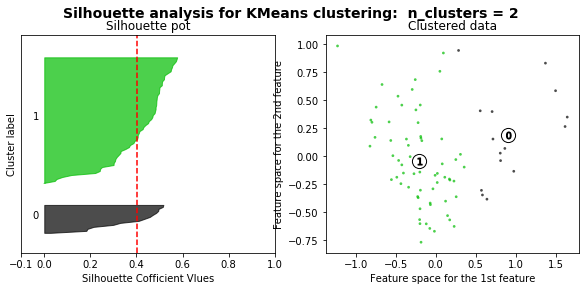

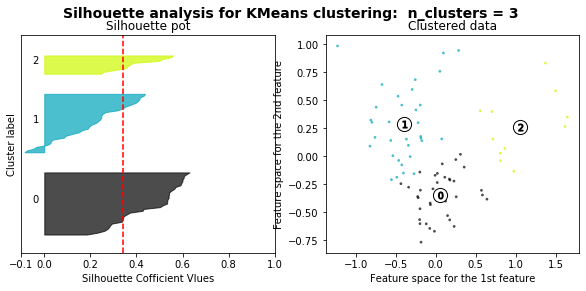

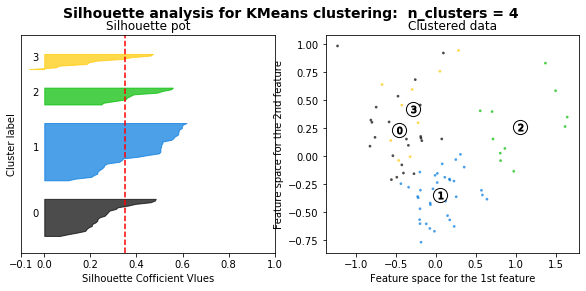

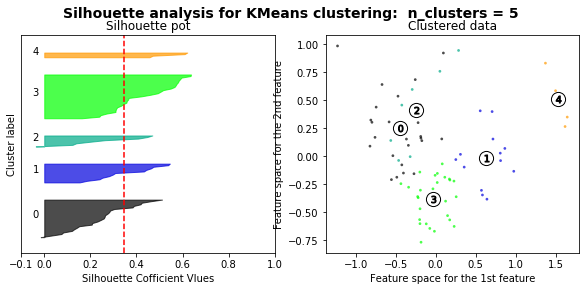

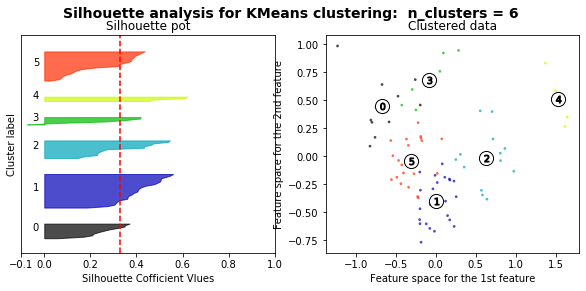

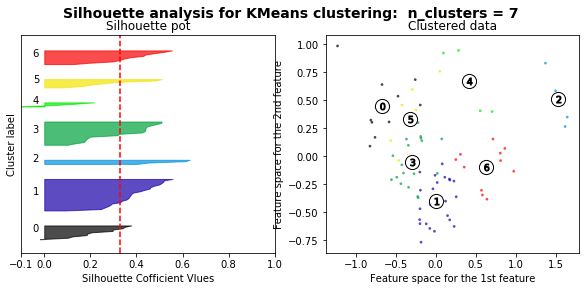

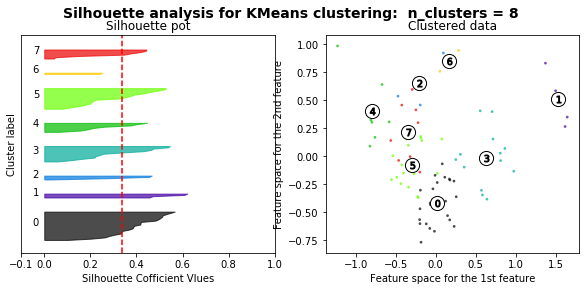

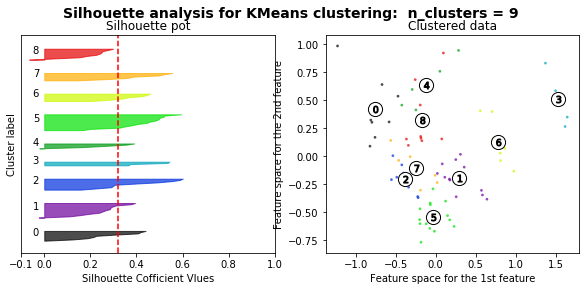

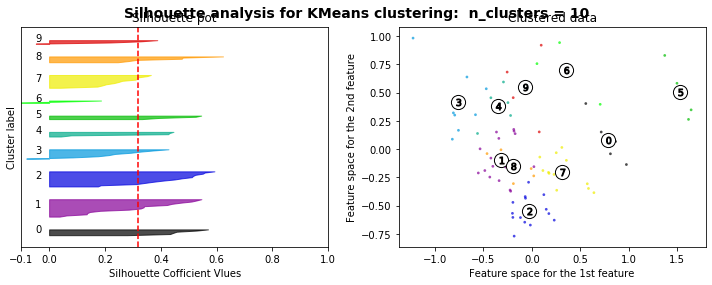

In [43]:
# Sihouette analysis enables you to compare results of K-means for different number of clusters
# Highest silhouette value indicates most variance explained 
clustersdf=pd.DataFrame(data=None, index=data.index)
range_n_clusters = [2, 3, 4, 5, 6, 7,8,9,10]

for n_clusters in range_n_clusters:
  
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
 
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("Silhouette pot")
    ax1.set_xlabel("Silhouette Cofficient Vlues")
    ax1.set_ylabel("Cluster label")

  
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering:  "
                  "n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

  
    clustersdf.insert(n_clusters-2, str(n_clusters), clusterer.labels_)

plt.tight_layout()
plt.show()
clustersdf.to_csv('E:\Jake\morphology_k-means_clusters.csv')

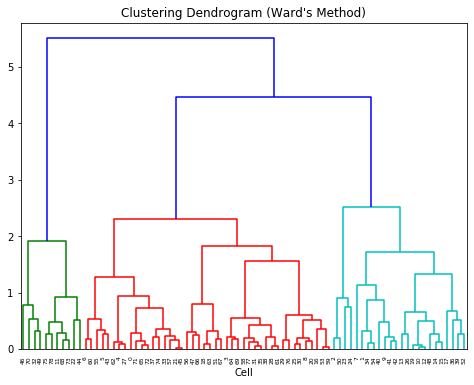

In [44]:
# Ward's method - hierarchical clustering (top down) 

import scipy.cluster.hierarchy as shc
plt.figure(figsize=(8, 6))
plt.title("Clustering Dendrogram (Ward's Method)")
plt.xlabel("Cell")
plt
dend = shc.dendrogram(shc.linkage(X, method='ward'))

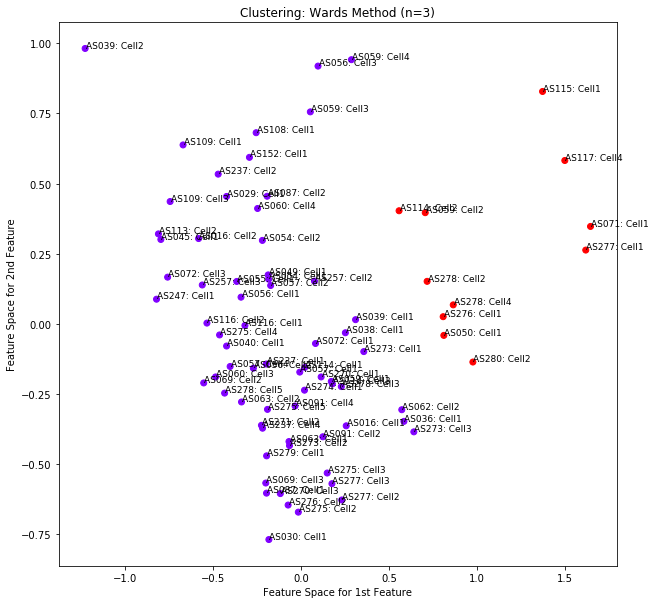

In [45]:
plt.figure(figsize=(10,10))
cluster = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_, cmap='rainbow')
plt.xlabel('Feature Space for 1st Feature')
plt.ylabel('Feature Space for 2nd Feature')
plt.title('Clustering: Wards Method (n=3)')

labels = data.index

P1 = X[:,0]
P2 = X[:,1]

for i,type in enumerate(labels):
    
    x = P1[i]
    y = P2[i]
    plt.text(x+0.003, y+0.003, type, fontsize=9)
    
    
plt.show()

In [46]:
df = pd.DataFrame(cluster.labels_, labels)
df.columns = ['Cluster']
df.index.name = 'Cell'

Group1 = df.loc[df['Cluster'] == 0]

Group2 = df.loc[df['Cluster'] == 1]

Group3 = df.loc[df['Cluster'] == 2]

# Group4 = df.loc[df['Cluster'] == 3]

# Group5 = df.loc[df['Cluster'] == 4]

a = pd.DataFrame(Group1.index)
b = pd.DataFrame(Group2.index)
c = pd.DataFrame(Group3.index)
# d = pd.DataFrame(Group4.index)
# e = pd.DataFrame(Group5.index)

clusters = pd.concat([a,b,c], ignore_index=True, axis=1)
clusters.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3']

clusters

,Cluster 1,Cluster 2,Cluster 3
0,AS016: Cell1,AS050: Cell1,NaN
1,AS016: Cell2,AS059: Cell2,NaN
2,AS029: Cell1,AS071: Cell1,NaN
3,AS030: Cell1,AS114: Cell2,NaN
4,AS036: Cell1,AS115: Cell1,NaN
5,AS038: Cell1,AS117: Cell4,NaN
6,AS039: Cell1,AS276: Cell1,NaN
7,AS039: Cell2,AS277: Cell1,NaN
8,AS040: Cell1,AS278: Cell2,NaN
9,AS045: Cell1,AS278: Cell4,NaN


Estimated number of clusters: 10


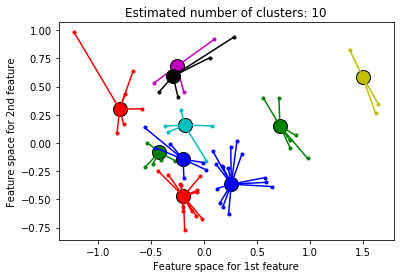

In [47]:
# Affinity Propagation 

# Perform affinity propagation 


# Need to figure out how to find optimal cluster value


af = AffinityPropagation(preference = None).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

# Plot result

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('Feature space for 1st feature')
plt.ylabel('Feature space for 2nd feature')
plt.show()

In [48]:
#ADD EPHYS CLUSTERS
%load_ext autoreload
%autoreload 2
import sys
sys.path
from ams_paq_utilities import *
from ams_utilities import *
import scipy
import matplotlib.pyplot as plt
%matplotlib notebook
import pyabf
import paq2py
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.interpolate
import itertools
from copy import deepcopy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import scipy.stats as ss 
from itertools import product
from sklearn.cluster import AffinityPropagation
from itertools import cycle

In [49]:
# Import data from spreadsheet 
df = pd.read_csv(r'\\163.1.248.177\share\Data\Ephys\2020-06-29_EphysPCs.csv', index_col=1)
df=df.T.iloc[[1,2]]
df.head()

Cell_ID,AS031: Cell1,AS032: Cell1,AS034: Cell1,AS035: Cell1,AS036: Cell1,AS039: Cell1,AS039: Cell2,AS040: Cell1,AS041: Cell1,AS045: Cell1,...,AS213: Cell1,AS214: Cell1,AS215: Cell2,AS217: Cell2,AS217: Cell3,AS218: Cell1,AS219: Cell3,AS220: Cell1,AS220: Cell2,AS221: Cell2
principal component 0,0.426637,4.291153,0.057112,3.200719,-0.266988,-0.540228,-0.430550,5.097091,0.327482,-0.53660,...,-1.169016,-2.402414,0.444586,-0.351209,0.118109,-2.471570,0.261253,-1.099304,4.061032,0.379611
principal component 1,0.738384,1.707385,-1.996059,-3.207650,-0.340855,1.070002,-1.024677,0.204398,0.658824,-1.62723,...,1.131339,0.731178,2.316623,-0.816810,1.419246,0.528826,2.172884,1.089224,3.053806,-1.416864


In [ ]:
# Create plot of PC space (components 1/2)
P1 = df.iloc[0]
P2 = df.iloc[1]
labels = df.columns


fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(P1,P2, color='blue')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two Component PCA Space (All Data)', fontsize = 20)
ax.grid()

for i,type in enumerate(labels):
    
    x = P1[i]
    y = P2[i]
    plt.text(x+0.03, y+0.03, type, fontsize=10)
    
    
plt.show()

In [ ]:
#K means clustering, n_clusters = 3
X = np.column_stack((P1,P2))

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(8, 8)


clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(X)

colors = cm.hsv(cluster_labels.astype(float) / 3)
ax1.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

centers = clusterer.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax1.set_title("Clustered data")
ax1.set_xlabel("Feature space for the 1st feature")
ax1.set_ylabel("Feature space for the 2nd feature")

In [ ]:
#Rename cells to fit my convention
cellNames=np.array(df.columns)
for j in range (1,7):
    cellNames= [i.replace('Cell'+str(j),'Cell0'+str(j)) for i in cellNames]
df.columns=cellNames

#Dataframe of ephys clusters by cell
clusterframe= pd.DataFrame(clusterer.labels_, index = cellNames, columns=['EPhys Cluster'])
clusterframe=clusterframe.rename_axis('CellID').T
clusterframe

In [ ]:
#Produces a dataframe of ephys clusters for n_clusters=3. A value of -1 means there is no ephys data for that cell
clusterframe1=pd.concat([clusterframe.T,  data], axis=1, join='inner')
clusterframe1=pd.DataFrame(clusterframe1.iloc[:,0])

ephyscellclusters=pd.DataFrame([-1]*len(data.index),index=data.index, columns=['Default Cluster'])

ephysClusters=pd.merge(clusterframe1, ephyscellclusters, left_index=True, right_index=True, how= 'right')
ephysClusters=pd.DataFrame(ephysClusters.agg(max,axis=1),columns=['EPhys Cluster'])
ephysClusters


In [ ]:
ephysClusters['PC1']=P1morph.values
ephysClusters['PC2']=P2morph.values
ephysClusters

In [ ]:
# Create plot of PC space (components 1/2)
import matplotlib.colors
import matplotlib.artist
import matplotlib.patches as patch
import matplotlib.cm

P1morph = ephysClusters['PC1']
P2morph = ephysClusters['PC2']
labs=[]
for i in range(0,len(data.index)):
    labs.append(data.index[i]+' '+str(df_all.iloc[0,i]))
labels = labs

colors=ephysClusters['EPhys Cluster']

fig, ax = plt.subplots(figsize=(10,10))
plot=plt.scatter(P1morph,P2morph, c=colors, cmap='Accent')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Morphology PCA Space with Ephys Clusters', fontsize = 20)
ax.grid()

legend1=ax.legend(*plot.legend_elements(),
                    loc="lower left", title="Ephys Clusters")

# ax.add_artist(legend1)
# for i,type in enumerate(labels):
    
#     x = P1[i]
#     y = P2[i]
#     plt.text(x+0.003, y+0.003, type, fontsize=9)
    
plt.savefig('E:\Jake\Morph_PCA_ephys_clusters')    
plt.show()